<center>

# Compulsory Assignment 2 

## Natural Language Processing [KAN - CSCO1002U]
<center>

### Importing Modules 

In [18]:
import pandas as pd 
import numpy as np
import matplotlib as plt
import seaborn as sns 

import nltk
import re
from nltk.corpus import stopwords
from nltk import word_tokenize, WordNetLemmatizer

### Importing the Data 

In [3]:
# Loading the data 
df = pd.read_csv("C:/Users/fredr/Downloads/archive (4)/articles1.csv")
df.head()

In [9]:
# Removing columns 
df.drop(df.columns[[0,1,2,4,5,6,7,8]], axis = 1, inplace = True)
df.head()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   publication  50000 non-null  object
 1   content      50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Text(0.5, 1.0, 'Publication Value Counts')

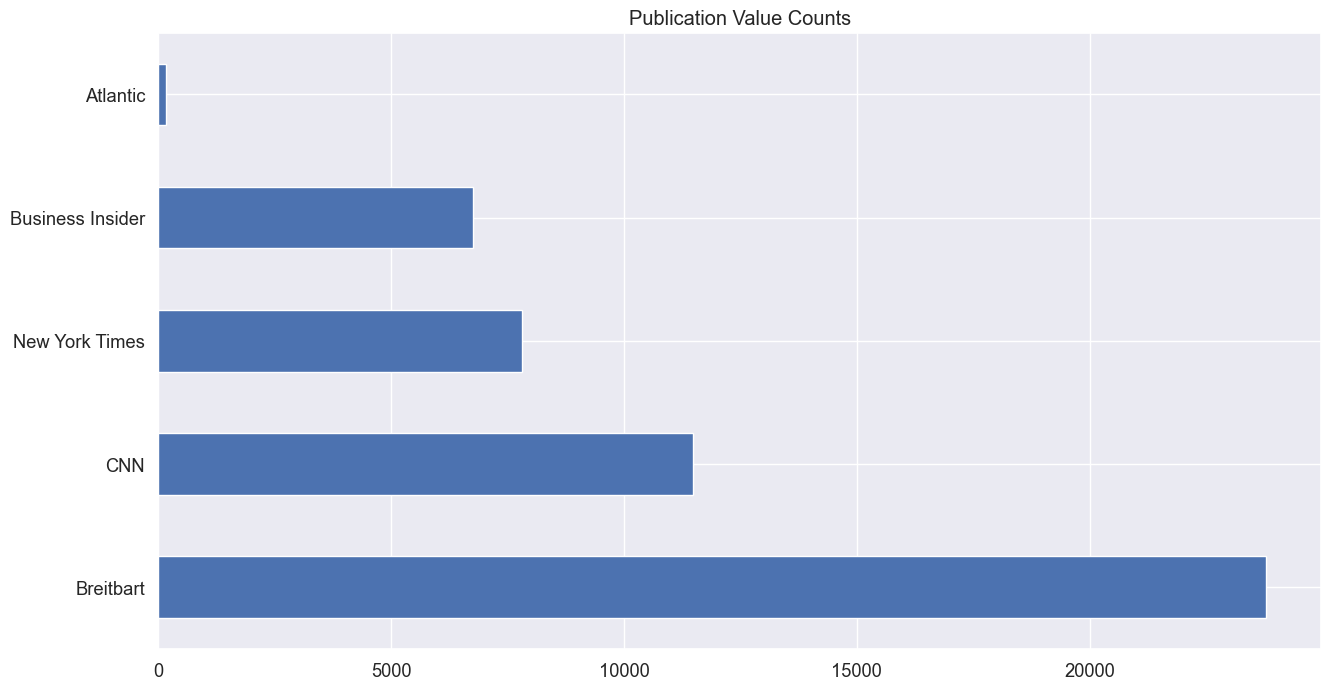

In [30]:
# Countplot shows the distribution of Publication
df['publication'].value_counts().plot(kind ='barh').set_title('Publication Value Counts')

In [13]:
# Function for Cleaning text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean(text):
    # Convert to lowercase
    text = text.lower()

    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)

    # Tokenize the article into words
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens 
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a cleaned article
    cleaned_text = ' '.join(tokens)

    return cleaned_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fredr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fredr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
# Cleaning the text
df['content'] = df['content'].apply(clean)

In [15]:
df.head()

,publication,content
0,New York Times,washington congressional republican new fear c...
1,New York Times,bullet shell get counted blood dry votive cand...
2,New York Times,walt disney bambi opened 1942 critic praised s...
3,New York Times,death may great equalizer isnt necessarily eve...
4,New York Times,seoul south korea north korea leader kim said ...


https://dagshub.com/raduga256/Text-Classification-with-NLP-Tf-Idf-vs-Word2Vec-vs-BERT/src/main/news_category_classification.ipynb